# LAB: quasi-Newton methods

Author : Alexandre Gramfort, Rémi Flamary

The objective of this lab session is to implement:
- Newton method
- DFP
- BFGS
- L-BFGS

And to investigate their behaviors.

You will need to use **line search methods**.

## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work as jupyter notebook one week after the lab on the **moodle platform**.
- This means that **each student in the pair sends the same file**.
- The **name of the file must be** constructed as in the next cell.

# Gentle reminder: no evaluation if you don't respect this EXACTLY

### How to construct the name of your file

In [1]:
# Change here using YOUR first and last names
fn1 = "ralph"
ln1 = "mouawad"
fn2 = "charles"
ln2 = "karrer"

filename = (
    "_".join(map(lambda s: s.strip().lower(), ["tp_newton", ln1, fn1, "and", ln2, fn2]))
    + ".ipynb"
)
print(filename)

tp_newton_mouawad_ralph_and_karrer_charles.ipynb


# Part 0: Demo using Gradient descent

First import the necessary libraries:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize

%matplotlib inline

Now import the necessary function from the optim_utils.py file.

In [4]:
from optim_utils import test_solver

You'll only need the `test_solver` function.

This function expects a function as parameter.

The signature of the function `optimizer` to pass should be the following:

`optimizer(x0, f, f_grad, f_hessian)`

First, an example with a gradient descent.

In [5]:
def gradient_descent(x0, f, f_grad, f_hessian=None):

    default_step = 0.01
    c1 = 0.0001
    c2 = 0.9
    max_iter = 200

    # This variable is used to indicate whether or not we want to print
    # monitoring information (iteration counter, function value and norm of the gradient)
    verbose = False

    all_x_k, all_f_k = [], []
    x = x0

    all_x_k.append(x.copy())
    all_f_k.append(f(x))

    for k in range(1, max_iter + 1):

        grad_x = f_grad(x)

        # Compute a step size using a line_search to satisfy the
        # strong Wolfe conditions
        step, _, _, new_f, _, new_grad = optimize.line_search(
            f, f_grad, x, -grad_x, grad_x, c1=c1, c2=c2
        )
        if step is None:
            print("Line search did not converge at iteration %s" % k)
            step = default_step

        x -= step * grad_x

        all_x_k.append(x.copy())
        all_f_k.append(new_f)

        l_inf_norm_grad = np.max(np.abs(new_grad))

        if verbose:
            print(
                "iter: %d, f: %.6g, l_inf_norm(grad): %.6g"
                % (k, new_f, l_inf_norm_grad)
            )

        if l_inf_norm_grad < 1e-6:
            break

    return np.array(all_x_k), np.array(all_f_k)

Now, call the `test_solver` function with this solver:


Running solver on case 1

Running solver on case 2

Running solver on case 3


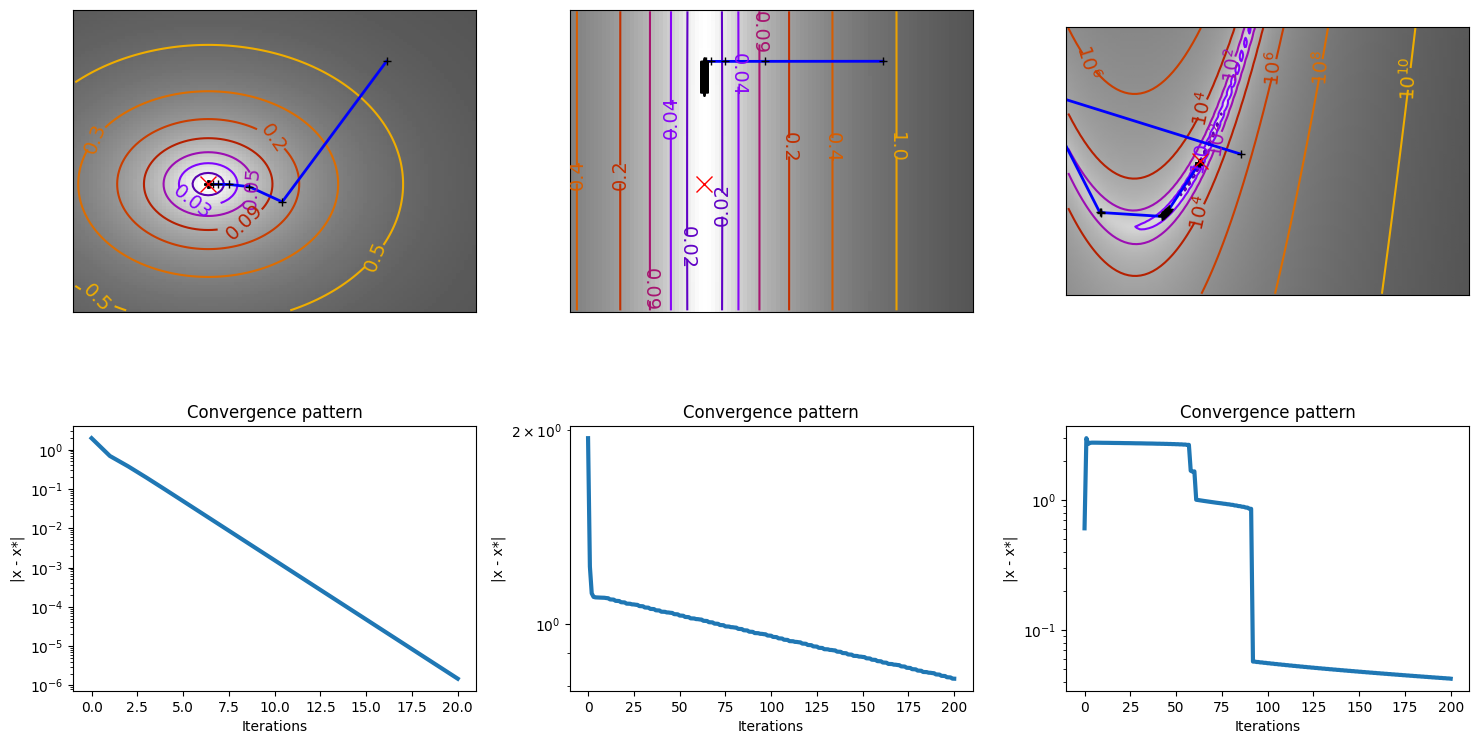

In [6]:
test_solver(gradient_descent)

It runs the algorithm on three functions:
- A non-convex Gaussian kernel ($f(x) = -\exp(-\|x\|^2)$)
- A badly conditioned quadratic function (but still strongly convex)
- The Rosenbrock function
    

# Part 1: Implement Newton method

<div class="alert alert-success">
    <b>QUESTION 1:</b>
     <ul>
         <li>Implement Newton's method. Beware that the Hessian SHOULD be regularized !</li>
         <li>Comment on what you observe. Do not describe the curves
             but rather comment if convergence rates match theoretical results.</li>
    </ul>
</div>

In [7]:
from scipy import linalg


def newton(x0, f, f_grad, f_hessian):
    default_step = 0.01
    c1 = 0.00001
    c2 = 0.95
    max_iter = 100
    lambda_threshold = 0.0001  # regularization threshold

    # This variable is used to indicate whether or not we want to print
    # monitoring information (iteration counter, function value and norm of the gradient)
    verbose = False

    all_x_k, all_f_k = list(), list()
    x = x0

    all_x_k.append(x.copy())
    all_f_k.append(f(x))

    for k in range(1, max_iter + 1):

        grad_x = f_grad(x)

        # Compute the Hessian, regularize it and compute the search direction d

        # TODO H = ..
        H = f_hessian(x)
        eig = linalg.eigvalsh(H)

        if np.min(eig) < lambda_threshold:

          H += (lambda_threshold - np.min(eig))*np.eye(H.shape[0])

        d = - np.linalg.solve(H, grad_x)
        # Compute a step size using a line_search to satisfy the
        # strong Wolfe conditions
        step, _, _, new_f, _, new_grad = optimize.line_search(
            f, f_grad, x, d, grad_x, c1=c1, c2=c2
        )
        if step is None:
            print("Line search did not converge at iteration %s" % k)
            step = default_step

        # Compute here the new value of x
        x += step * d

        all_x_k.append(x.copy())
        all_f_k.append(new_f)

        l_inf_norm_grad = np.max(np.abs(new_grad))

        if verbose:
            print(
                "iter: %d, f: %.6g, l_inf_norm(grad): %.6g"
                % (k, new_f, l_inf_norm_grad)
            )

        if l_inf_norm_grad < 1e-6:
            break

    return np.array(all_x_k), np.array(all_f_k)


Running solver on case 1

Running solver on case 2

Running solver on case 3


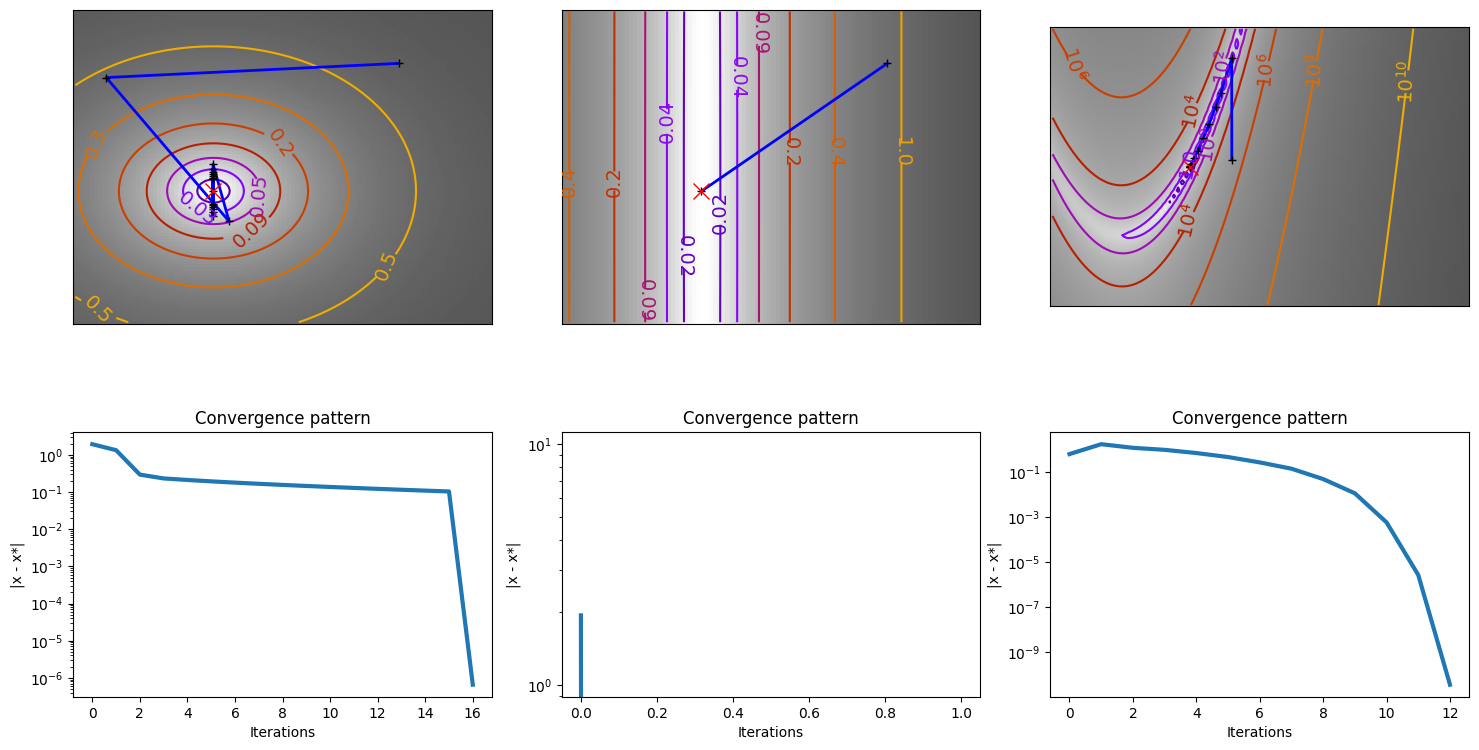

In [8]:
test_solver(newton)

WRITE YOUR COMMENTS HERE

First we regularized our hessian matrix to make it PSD for a better stability. Then we should expect Newton's method to converge very fast compared to gradient descent.

1) Gaussian Kernel:The function is non-convex. However we regularized the hessian. The issue with the algorithm is the starting point: if we start from a point that is far from the optimal solution, we might diverge. The step size helps overcome this issue but we can see that clearly Newton's method started with a divergence behavior.

2) The problem has a strongly convex function but ill-conditioned. However, we can see that Newton's method converged in one iteration. This is proved theoretically that one newton step is the solution of the linear system. Hence the algorithm doesn't depend on the conditioning of the problem but only on the fact that the hessian is PSD and we don't start far from optimality.

3) Gradient descent's convergence behavior showed the algorithm struggled. However, newton's method converged much faster due to the proximity to the optimal solution.

# Part 2: Implement DFP algorithm

<div class="alert alert-success">
    <b>QUESTION 2:</b>
     <ul>
         <li>Now, implement the DFP algorithm using the formula for $B$ in the slides.</li>
         <li>Comment on what you observe. Focus on the explanation, not on describing the curves!</li>
         <li>Isn't there a contradiction on the quadratic functions with what we've seen in class? What is going on?</li>
    </ul>
</div>

In [9]:
def dfp(x0, f, f_grad, f_hessian):
    default_step = 0.01
    c1 = 0.0001
    c2 = 0.95
    max_iter = 200

    # This variable is used to indicate whether or not we want to print
    # monitoring information (iteration counter, function value and norm of the gradient)
    verbose = False

    all_x_k, all_f_k = list(), list()
    x = x0

    all_x_k.append(x.copy())
    all_f_k.append(f(x))

    B = np.eye(len(x))  # inverse Hessian approximation, start from Id

    grad_x = f_grad(x)

    for k in range(1, max_iter + 1):

        # Compute the search direction
        d = np.dot(B, -grad_x)

        # Compute a step size using a line_search to satisfy the
        # strong Wolfe conditions
        step, _, _, new_f, _, new_grad = optimize.line_search(
            f, f_grad, x, d, grad_x, c1=c1, c2=c2
        )

        if step is None:
            print("Line search did not converge at iteration %s" % k)
            step = default_step

        # Compute the new value of x
        s = step * d
        x = x + s
        y = new_grad - grad_x
        ################################################################
        # Update the inverse Hessian approximation

        # TODO B = ...
        B += (np.outer(s, s)) / (np.dot(s, y)) - (np.dot(np.dot(B, np.outer(y,y)), B) / np.dot(y, np.dot(B, y))) ## could have used @ instead of np.dot
        ################################################################

        all_x_k.append(x.copy())
        all_f_k.append(new_f)

        l_inf_norm_grad = np.max(np.abs(new_grad))

        if verbose:
            print(
                "iter: %d, f: %.6g, l_inf_norm(grad): %.6g"
                % (k, new_f, l_inf_norm_grad)
            )

        if l_inf_norm_grad < 1e-6:
            break

        grad_x = new_grad

    return np.array(all_x_k), np.array(all_f_k)


Running solver on case 1

Running solver on case 2

Running solver on case 3


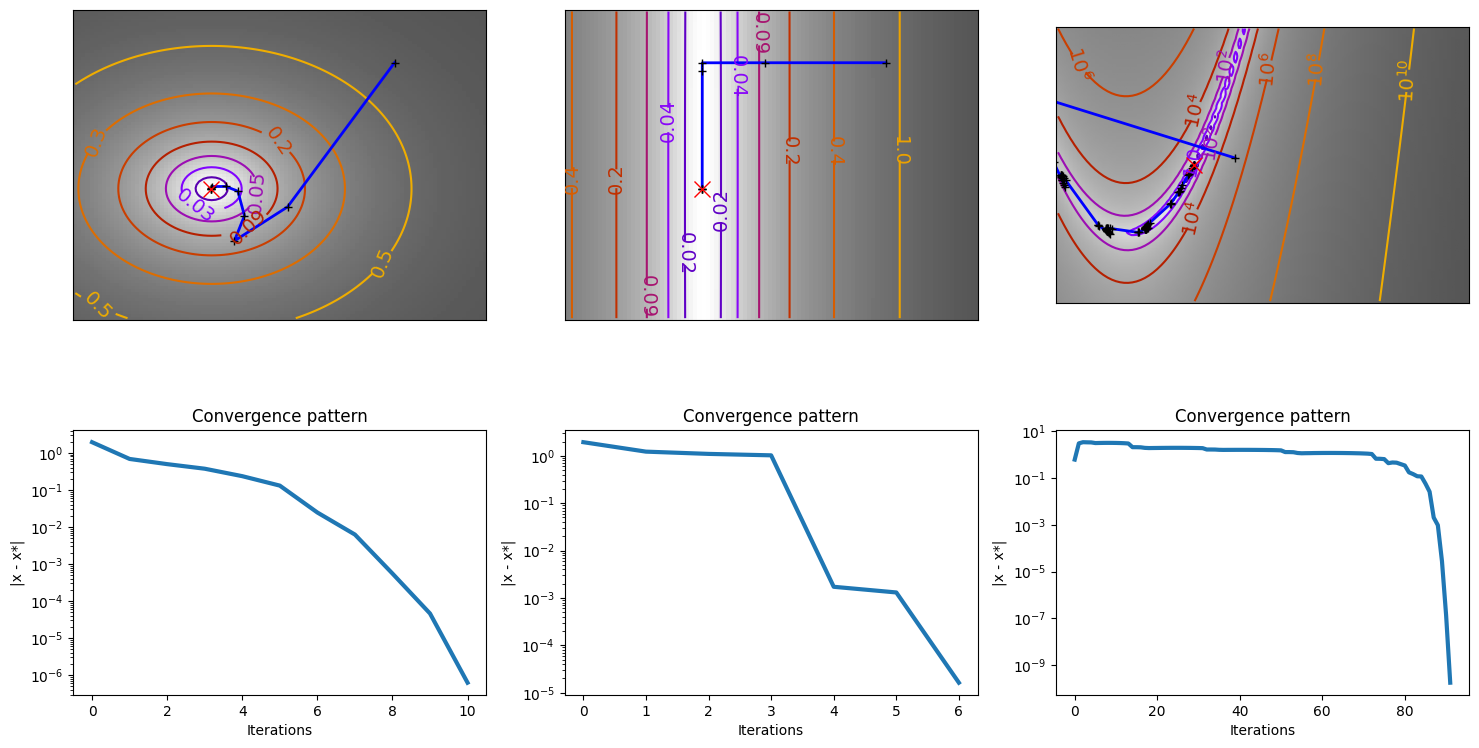

In [10]:
test_solver(dfp)

WRITE YOUR COMMENTS HERE

1- For the gaussian kernel, DFP has a better convergence behavior than Newton (we didn't start with a divergence).

2- For the badly conditioned problem, we are surprised to see that we didn't converge in one iteration like newton's method. It is logic to see this because the Hessian is being estimated throughout the training procedure, hence it cannot converge directly. But the algorithm didn't suffer from a divergence behavior due to the line search method for the step size.

3- For the Rosenbrock function we converged in 'n' iterations but clearly it took more time to converge. However the step size might be the reason behind the time it took for convergence.

# Part 3: Implement BFGS algorithm


<div class="alert alert-success">
    <b>QUESTION 3:</b>
     <ul>
         <li>You should now implement BFGS, using the formula for $B_t$ seen in the slides.</li>
         <li>Comment on what you observe.</li>
    </ul>
</div>

In [13]:
def bfgs(x0, f, f_grad, f_hessian):
    default_step = 0.01
    c1 = 0.0001
    c2 = 0.9
    max_iter = 100

    # This variable is used to indicate whether or not we want to print
    # monitoring information (iteration counter, function value and norm of the gradient)
    verbose = False

    all_x_k, all_f_k = list(), list()
    x = x0

    all_x_k.append(x.copy())
    all_f_k.append(f(x))

    B = np.eye(len(x))  # Hessian approximation

    grad_x = f_grad(x)

    for k in range(1, max_iter + 1):

        # Compute the search direction
        # d = -np.dot(B, grad_x) we need the to inverse B not use B. I will do this by solving the linear system
        d = np.linalg.solve(B, -grad_x)

        # Compute a step size using a line_search to satisfy the
        # strong Wolfe conditions
        step, _, _, new_f, _, new_grad = optimize.line_search(
            f, f_grad, x, d, grad_x, c1=c1, c2=c2
        )

        if step is None:
            print("Line search did not converge at iteration %s" % k)
            step = default_step

        # Compute the new value of x
        s = step * d
        x += s
        y = new_grad - grad_x
        ##################################################################
        # Update the inverse Hessian approximation

        # TODO B =
        B = B + (np.outer(y, y) / np.dot(y, s)) - (np.dot(np.dot(B, np.outer(s,s)), B) / np.dot(s, np.dot(B, s)))
        ##################################################################

        all_x_k.append(x.copy())
        all_f_k.append(new_f)

        l_inf_norm_grad = np.max(np.abs(new_grad))

        if verbose:
            print(
                "iter: %d, f: %.6g, l_inf_norm(grad): %.6g"
                % (k, new_f, l_inf_norm_grad)
            )

        if l_inf_norm_grad < 1e-6:
            break

        grad_x = new_grad

    return np.array(all_x_k), np.array(all_f_k)


Running solver on case 1

Running solver on case 2

Running solver on case 3


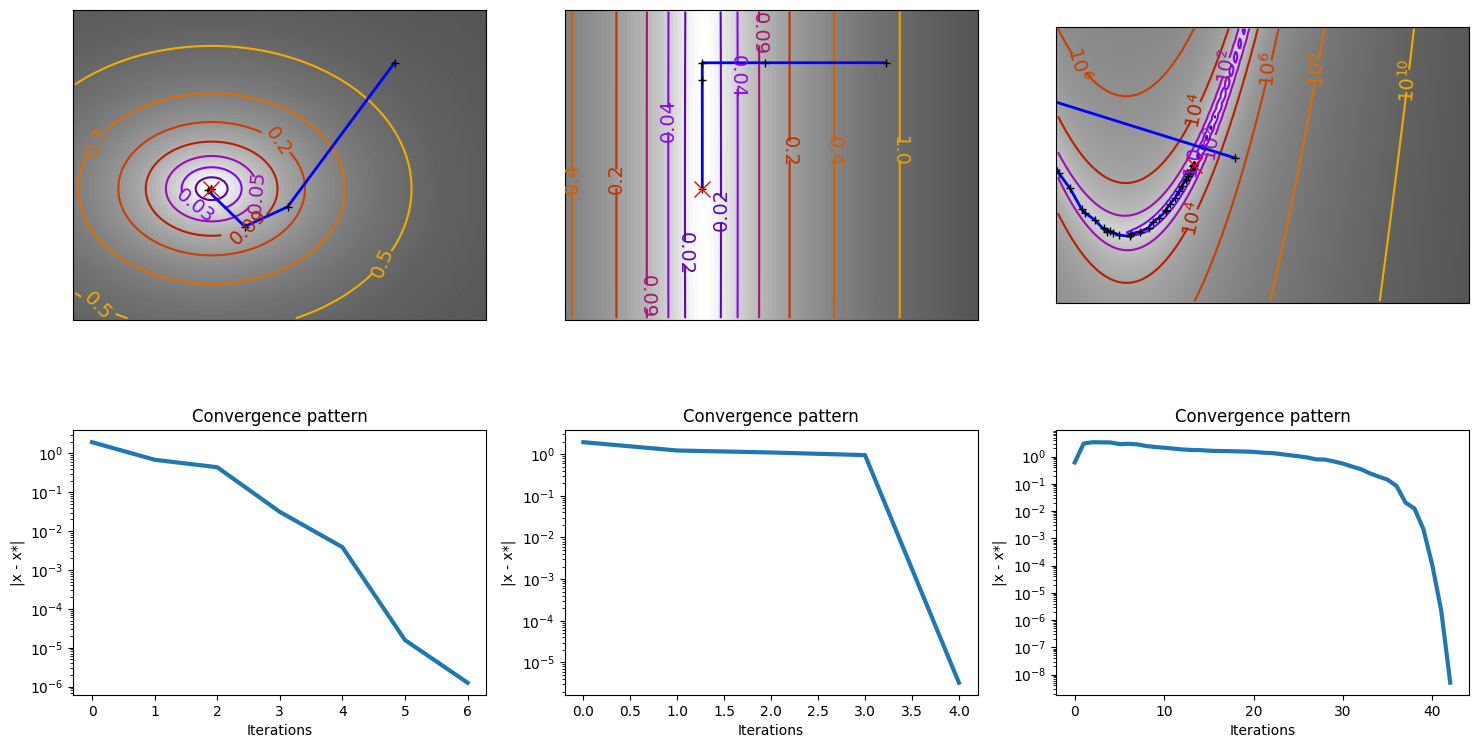

In [14]:
test_solver(bfgs)

WRITE YOUR COMMENTS HERE

We observe very similar results compared to DFP. It is a little bit better for the 2nd case.

The reason is that BFGS and DFP are very similar since we're just switching s and y. We are still using this idea of approximating the Hessian matrix. The algorithm for quadratic problems should converge for at most n iterations with the optimal size. In our case we are choosing a good step size with line search. It is less sensitive to approximate step sizes compared to DFP which is why it is slightly better in some cases (test case2).

# Part 4: Implement L-BFGS algorithm


<div class="alert alert-success">
    <b>QUESTION 4:</b>
     <ul>
         <li>You should now implement the L-BFGS algorithm. We ask you to code the two-loops recursion in the function called two_loops.</li>
         <li>Comment briefly on what you see.</li>
    </ul>
</div>

**Remark:** The question is hard. Consider this as a bonus question.

In [15]:
def two_loops(grad_x, m, s_list, y_list, mu_list, B0):
    '''
    Parameters
    ----------
    grad_x : ndarray, shape (n,)
        gradient at the current point

    m : int
        memory size

    s_list : list of length m
        the past m values of s

    y_list : list of length m
        the past m values of y

    mu_list : list of length m
        the past m values of mu

    B0 : ndarray, shape (n, n)
        Initial inverse Hessian guess

    Returns
    -------
    r :  ndarray, shape (n,)
        the L-BFGS direction
    '''
    q = grad_x.copy()
    alpha_list = []
    # TODO : first loop
    for i in reversed(range(len(s_list))): # k-1 to k-m
      alpha= mu_list[i] * np.dot(s_list[i], q)
      alpha_list.append(alpha)
      q -= alpha * y_list[i]
    alpha_list.reverse()
    r = np.dot(B0, q)
    # TODO: second loop
    for i in range(len(s_list)):
      beta = mu_list[i] * np.dot(y_list[i], r)
      r += (alpha_list[i] - beta) * s_list[i]
    return -r

In [16]:
def lbfgs(x0, f, f_grad, f_hessian):
    default_step = 0.01
    c1 = 0.0001
    c2 = 0.9
    max_iter = 100
    m = 2

    # This variable is used to indicate whether or not we want to print
    # monitoring information (iteration counter, function value and norm of the gradient)
    verbose = False

    all_x_k, all_f_k = list(), list()
    x = x0

    all_x_k.append(x.copy())
    all_f_k.append(f(x))

    B0 = np.eye(len(x))  # Hessian approximation

    grad_x = f_grad(x)

    y_list, s_list, mu_list = [], [], []
    for k in range(1, max_iter + 1):

        # Compute the search direction
        d = two_loops(grad_x, m, s_list, y_list, mu_list, B0)

        # Compute a step size using a line_search to satisfy the
        # strong Wolfe conditions
        step, _, _, new_f, _, new_grad = optimize.line_search(
            f, f_grad, x, d, grad_x, c1=c1, c2=c2
        )

        if step is None:
            print("Line search did not converge at iteration %s" % k)
            step = default_step

        # Compute the new value of x
        s = step * d
        x += s
        y = new_grad - grad_x
        mu = 1 / np.dot(y, s)
        ##################################################################
        # Update the memory
        y_list.append(y.copy())
        s_list.append(s.copy())
        mu_list.append(mu)
        if len(y_list) > m:
            y_list.pop(0)
            s_list.pop(0)
            mu_list.pop(0)
        ##################################################################

        all_x_k.append(x.copy())
        all_f_k.append(new_f)

        l_inf_norm_grad = np.max(np.abs(new_grad))

        if verbose:
            print(
                "iter: %d, f: %.6g, l_inf_norm(grad): %.6g"
                % (k, new_f, l_inf_norm_grad)
            )

        if l_inf_norm_grad < 1e-6:
            break

        grad_x = new_grad

    return np.array(all_x_k), np.array(all_f_k)


Running solver on case 1

Running solver on case 2

Running solver on case 3


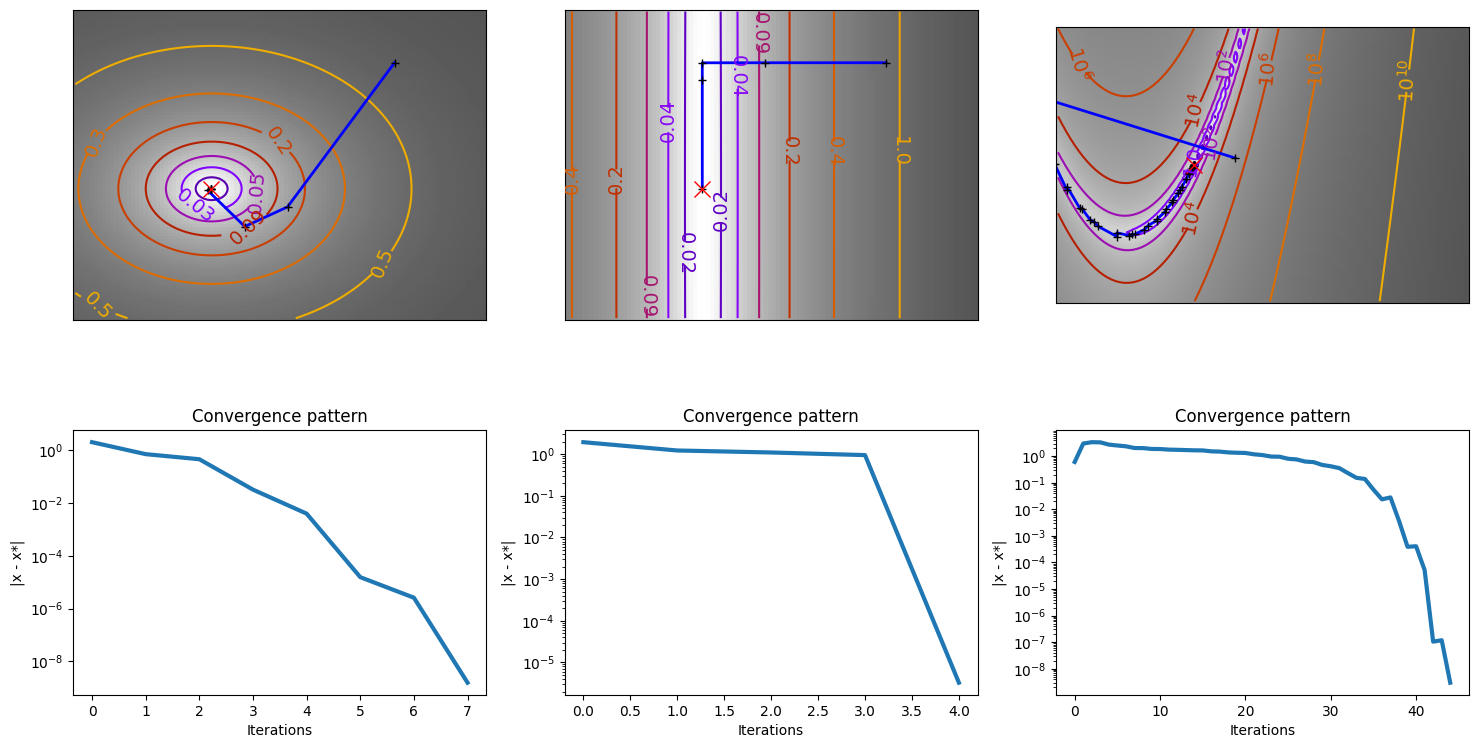

In [17]:
test_solver(lbfgs)

WRITE YOUR COMMENTS HERE

In terms of convergence behavior, we observe the same one as BFGS implemented just before. This is because LBFGS is the same algorithm but is more memory/ computationally-efficient. This is because we are only storing the last 'm' pairs of vectors (s,y) to compute the Hessian approximation instead of storing a huge hessian matrix that has a size of nxn, where n can be millions in some ML applications (computer vision for example).